In [1]:
import os
import random 
import numpy as np
import pickle
from subprocess import call
from shutil import copyfile
from scipy.io import wavfile
import scipy.misc
import librosa
import time
from IPython.core.display import HTML
import argparse
import os

import tensorflow as tf
import tensorflow.contrib.slim as slim
import tensorflow.contrib.slim.nets

%matplotlib inline
import matplotlib.pyplot as plt
%pylab inline

from matplotlib import cm

Populating the interactive namespace from numpy and matplotlib


/home/austin/tensorflow/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [ ]:
# Define some helper functions before we begin.

In [3]:
def list_images(directory):
    """
    Get all the images and labels in directory/label/*.jpg
    """
    labels = [f for f in os.listdir(directory) if os.path.isdir(os.path.join(directory, f))]
    # Sort the labels so that training and validation get them in the same order
    labels.sort()

    files_and_labels = []
    for label in labels:
        for f in os.listdir(os.path.join(directory, label)):
            files_and_labels.append((os.path.join(directory, label, f), label))

    filenames, labels = zip(*files_and_labels)
    filenames = list(filenames)
    labels = list(labels)
    unique_labels = sorted(list(set(labels)), key=int)

    label_to_int = {}
    for i, label in enumerate(unique_labels, 1):
        label_to_int[label] = i

    labels = [label_to_int[l] for l in labels]

    return filenames, labels


def list_images_split(directory, num_split=2):
    """
    Get all the images and labels in directory/label/*.jpg
    """
    labels = [f for f in os.listdir(directory) if os.path.isdir(os.path.join(directory, f))]
    # Sort the labels so that training and validation get them in the same order
    labels.sort()
    train_files_and_labels = []
    val_files_and_labels = []
    
    balance_factors_path = os.path.join(directory, 'balance_factors.txt')
    if os.path.isfile(balance_factors_path):
        print("Balancing training data using balance_factors.txt")
        balance_factors = read_counts_file(balance_factors_path)
        for label in labels:
            for count, f in enumerate(reversed(os.listdir(os.path.join(directory, label)))):
                if count < num_split:
                    val_files_and_labels.append((os.path.join(directory, label, f), label))
                else:
                    for i in range(balance_factors[label]):
                        train_files_and_labels.append((os.path.join(directory, label, f), label))
    else:
        for label in labels:
            for count, f in enumerate(reversed(os.listdir(os.path.join(directory, label)))):
                if count < num_split:
                    val_files_and_labels.append((os.path.join(directory, label, f), label))
                else:
                    train_files_and_labels.append((os.path.join(directory, label, f), label))

    train_filenames, train_labels = zip(*train_files_and_labels)
    train_filenames = list(train_filenames)
    train_labels = list(train_labels)
    unique_labels = sorted(list(set(train_labels)), key=int)
    label_to_int = {}
    for i, label in enumerate(unique_labels, 1):
        label_to_int[label] = i
    train_labels = [label_to_int[l] for l in train_labels]
    
    val_filenames, val_labels = zip(*val_files_and_labels)
    val_filenames = list(val_filenames)
    val_labels = list(val_labels)
    unique_labels = sorted(list(set(val_labels)), key=int)
    label_to_int = {}
    for i, label in enumerate(unique_labels, 1):
        label_to_int[label] = i
    val_labels = [label_to_int[l] for l in val_labels]

    return train_filenames, train_labels, val_filenames, val_labels


def read_label_file(path):
    """Reads the labels file and returns a mapping from ID to class name.

    Args:
    dataset_dir: The directory in which the labels file is found.
    filename: The filename where the class names are written.

    Returns:
    A map from a label (integer) to class name.
    """
    labels_filename = path
    with tf.gfile.Open(labels_filename, 'rb') as f:
        lines = f.read().decode()
    lines = lines.split('\n')
    lines = filter(None, lines)

    labels_to_class_names = {}
    for line in lines:
        index = line.index(':')
        labels_to_class_names[int(line[:index])] = line[index+1:]
    return labels_to_class_names


def probs_to_ranks(array):
    # Return ranks for each entry in an array - e.g. the highest scoring element would receive rank 1, etc.
    output = [0] * len(array)
    for i, x in enumerate(sorted(range(len(array)), key=lambda y: array[y], reverse=True)):
        output[x] = i + 1
    return output

# Hyperparameter scatterplot.

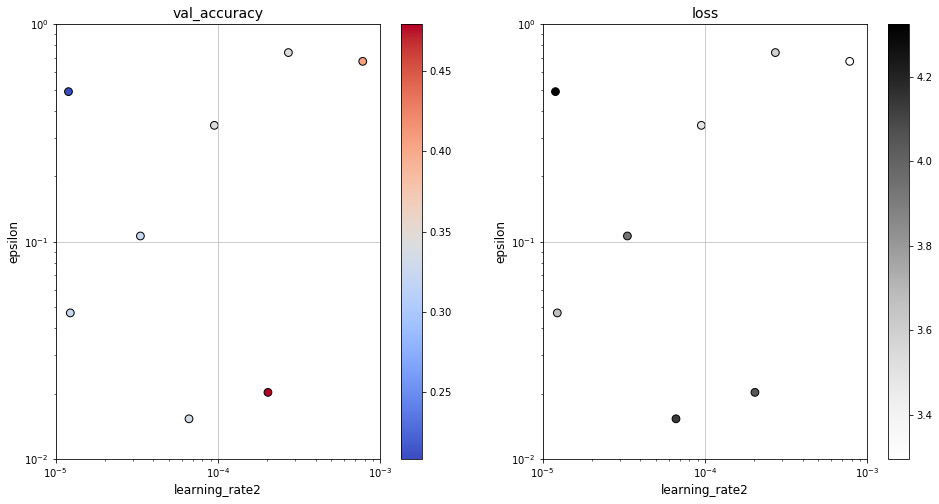

In [20]:
learn_dir = 'runs'
num_runs = 8 #31
run_labels = [str(i) for i in range(700, 700+num_runs)]

lr = 'learning_rate2'
acc = 'val_accuracy'
params = [acc, 'epsilon', lr, 'loss']
data = {}
for param in params:
    data[param] = []

for label in run_labels:
    trial_dir = os.path.join(learn_dir, label)
    params_path = os.path.join(trial_dir, 'params.txt')
    trial_data = read_params_file(params_path)
    for param in params:
        data[param].append(trial_data[param])

#fig = plt.figure(figsize=(12,6))

fig, ax = plt.subplots(1,2,figsize=(16,8))
ax[0].set_title(acc,fontsize=14)
ax[0].set_xlabel(lr,fontsize=12)
ax[0].set_ylabel("epsilon",fontsize=12)
ax[0].grid(True, linestyle='-', color='0.75')
x = data[lr]
y = data['epsilon']
z = data[acc]

# scatter with colormap mapping to z value
ix0 = ax[0].scatter(x, y, s=60, c=z, marker='o', cmap='coolwarm', edgecolors='black');
fig.colorbar(ix0, ax=ax[0])
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlim([1e-5, 1e-3])
ax[0].set_ylim([1e-2, 1e0])


ax[1].set_title("loss",fontsize=14)
ax[1].set_xlabel(lr,fontsize=12)
ax[1].set_ylabel("epsilon",fontsize=12)
ax[1].grid(True, linestyle='-', color='0.75')
x = data[lr]
y = data['epsilon']
z = data['loss']

# scatter with colormap mapping to z value
ix1 = ax[1].scatter(x, y, s=60, c=z, marker='o', cmap='Greys', edgecolors='black');
#ax[1].clim(0, 10)
fig.colorbar(ix1, ax=ax[1])
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlim([1e-5, 1e-3])
ax[1].set_ylim([1e-2, 1e0])


plt.show()




In [124]:
min_loss = min(data['loss'])
idx = data['loss'].index(min_loss)
print('Min loss (%f) at LR1=%f and epsilon=%f' % (min_loss, data['learning_rate1'][idx], data['epsilon'][idx]))

Min loss (3.599932) at LR1=0.006149 and epsilon=0.928305


In [125]:
loss_s = sorted(data['loss'])
lr1_s = [x for _, x in sorted(zip(data['loss'],data['learning_rate1']), key=lambda pair: pair[0])]
eps_s = [x for _, x in sorted(zip(data['loss'],data['epsilon']), key=lambda pair: pair[0])]

In [126]:
print(loss_s)
print(lr1_s)
print(eps_s)

[3.5999317968, 3.65997490574, 3.67368123858, 3.67811651762, 3.73466937675, 3.76025348811, 3.82516105314, 3.86706911368, 3.89020620929, 3.89492248763, 3.91901515583, 4.00563443615, 4.21233124418, 4.45430057787, 4.54018137479, 4.66520290629, 4.90396635847, 5.14363210758, 5.17343486445, 5.35407437891, 5.41505319243, 6.74802331029, 6.91392747521, 7.21263971728, 7.70988648555, 8.27358478943, 9.96740664806, 12.4798055228, 35.6323208204, 38.4549797271, 103.307255759]
[0.00614943730057, 0.00101627733131, 0.0017084886891, 0.00137591692704, 0.00272865869487, 0.00633458757712, 0.00130457046723, 0.00254008119948, 0.00257455298633, 0.00110650880493, 0.00410340697937, 0.00492253386013, 0.00181581946112, 0.0157595000743, 0.00125945686153, 0.00203012064587, 0.0343626734983, 0.00290477785307, 0.012713073536, 0.00777217246711, 0.00148774306869, 0.0212193486543, 0.00367475101777, 0.0654750076626, 0.00455416577036, 0.0178828091481, 0.031468814457, 0.00826097415968, 0.0541288888133, 0.0471068878862, 0.0640

# CHECK GRAPH COLLECTIONS

In [12]:
idx = 44
run_id = str(idx)

args = {}
args['data_dir'] = '../data'
args['train_dir'] = os.path.join(args['data_dir'], 'train')
args['val_dir'] = os.path.join(args['data_dir'], 'test')
args['labels_path'] = os.path.join(args['data_dir'], 'labels.txt')
args['snip_dir'] = '../snips'
args['trial_dir'] = run_id
args['save_dir'] = os.path.join(args['trial_dir'], 'save')
args['summary_dir'] = os.path.join(args['trial_dir'], 'summary')
args['log_dir'] = os.path.join(args['trial_dir'], 'logs')
args['params_path'] = os.path.join(args['trial_dir'], 'params.txt')
args['model_path'] = 'checkpoints/inception_v3.ckpt'
args['batch_size'] = 8
args['num_workers'] = 4
args['num_epochs1'] = 100
args['num_epochs2'] = 0
args['learning_rate1'] = 10 ** np.random.uniform(-1, -3)
args['learning_rate2'] = 10 ** np.random.uniform(-3, -5)
args['epsilon'] = 10 ** np.random.uniform(0, -2)
args['dropout_keep_prob'] = 0.8  ## 0.5
args['weight_decay'] = 0.00004   ## 5e-4

params = {}
params['run_id'] = args['trial_dir']
params['num_epochs1'] = args['num_epochs1']
params['num_epochs2'] = args['num_epochs2']
params['learning_rate1'] = args['learning_rate1']
params['learning_rate2'] = args['learning_rate2']
params['epsilon'] = args['epsilon']
params['loss'] = 0.0
params['train_accuracy'] = 0.0
params['val_accuracy'] = 0.0



In [15]:
save_dir_logits = os.path.join(args['save_dir'], 'logits')
save_dir_full = os.path.join(args['save_dir'], 'full')
summary_dir_logits = os.path.join(args['summary_dir'], 'logits')
summary_dir_full = os.path.join(args['summary_dir'], 'full')

for directory in [save_dir_logits, save_dir_full, summary_dir_logits, summary_dir_full]:
    if not os.path.exists(directory):
        os.makedirs(directory)

save_path_logits = os.path.join(save_dir_logits, 'logits')
save_path_full = os.path.join(save_dir_full, 'full')

train_filenames, train_labels = list_images(args['train_dir'])
val_filenames, val_labels = list_images(args['val_dir'])
assert set(train_labels) == set(val_labels),\
       "Train and val labels don't correspond:\n{}\n{}".format(set(train_labels),
                                                               set(val_labels))
num_classes = len(set(train_labels)) + 1

g1 = tf.Graph()
with g1.as_default():
    def _parse_function(filename, label):
        image_string = tf.read_file(filename)
        image_decoded = tf.image.decode_jpeg(image_string, channels=3)
        image = tf.image.convert_image_dtype(image_decoded, dtype=tf.float32)
        image.set_shape([224, 341, 3])

        # Want a 3.5 second slice of 4.0 second spectrogram to be square (299x299) - set new_width accordingly
        new_height = tf.to_int32(299.0)
        new_width = tf.to_int32(319.0)
        crop_height = tf.to_int32(299.0)
        crop_width = tf.to_int32(299.0)

        image = tf.image.resize_images(image, [new_height, new_width])  # (2)

        max_offset_height = tf.reshape(new_height - crop_height + 1, [])
        max_offset_width = tf.reshape(new_width - crop_width + 1, [])
        offset_height = tf.constant(0, dtype=tf.int32)
        offset_width = tf.random_uniform([], maxval=max_offset_width, dtype=tf.int32)

        original_shape = tf.shape(image)
        cropped_shape = tf.stack([crop_height, crop_width, original_shape[2]])

        offsets = tf.to_int32(tf.stack([offset_height, offset_width, 0]))
        image = tf.slice(image, offsets, cropped_shape)
        image.set_shape([299, 299, 3])
        #image = tf.reshape(image, cropped_shape)

        image = tf.subtract(image, 0.5)
        image = tf.multiply(image, 2.0)

        return image, label

    def variable_summaries(var):
        """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
        with tf.name_scope('summaries'):
            mean = tf.reduce_mean(var)
            tf.summary.scalar('mean', mean)
            with tf.name_scope('stddev'):
                stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
                tf.summary.scalar('stddev', stddev)
                tf.summary.scalar('max', tf.reduce_max(var))
                tf.summary.scalar('min', tf.reduce_min(var))
                tf.summary.histogram('histogram', var)


    # Training dataset
    train_dataset = tf.data.Dataset.from_tensor_slices((train_filenames, train_labels))
    train_dataset = train_dataset.shuffle(buffer_size=len(train_filenames))
    train_dataset = train_dataset.map(_parse_function, num_parallel_calls=args['num_workers'])
    batched_train_dataset = train_dataset.batch(args['batch_size'])
    # Validation dataset
    val_dataset = tf.data.Dataset.from_tensor_slices((val_filenames, val_labels))
    val_dataset = val_dataset.map(_parse_function, num_parallel_calls=args['num_workers'])
    batched_val_dataset = val_dataset.batch(args['batch_size'])

    iterator = tf.contrib.data.Iterator.from_structure(batched_train_dataset.output_types,
                                                       batched_train_dataset.output_shapes)
    images, labels = iterator.get_next()
    tf.summary.image('processed_image', images)
    train_init_op = iterator.make_initializer(batched_train_dataset)
    val_init_op = iterator.make_initializer(batched_val_dataset)
    is_training = tf.placeholder(tf.bool)
    
    inception = tf.contrib.slim.nets.inception
    with slim.arg_scope(inception.inception_v3_arg_scope(weight_decay=args['weight_decay'])):
        logits, end_points = inception.inception_v3(images, num_classes=num_classes, is_training=is_training,
                               dropout_keep_prob=args['dropout_keep_prob'])

    layers_exclude = ['InceptionV3/Logits', 'InceptionV3/AuxLogits']
    variables_to_restore = tf.contrib.framework.get_variables_to_restore(exclude=layers_exclude)
    init_fn = tf.contrib.framework.assign_from_checkpoint_fn(args['model_path'], variables_to_restore)

    all_variables = tf.contrib.framework.get_variables_to_restore()
    restore_fn = tf.contrib.framework.assign_from_checkpoint_fn(save_dir_full, all_variables)

    logits_variables = tf.contrib.framework.get_variables('InceptionV3/Logits')
    logits_variables += tf.contrib.framework.get_variables('InceptionV3/AuxLogits') 
    logits_init = tf.variables_initializer(logits_variables)

    tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
    loss = tf.losses.get_total_loss()

    logits_optimizer = tf.train.AdamOptimizer(learning_rate=args['learning_rate1'], 
                                                  epsilon=args['epsilon'])
    logits_train_op = logits_optimizer.minimize(loss, var_list=logits_variables)

    full_optimizer = tf.train.AdamOptimizer(learning_rate=args['learning_rate2'],
                                                epsilon=args['epsilon'])
    full_train_op = full_optimizer.minimize(loss)

    kw_predictions = tf.argmax(end_points['Predictions'], 1)
    kw_probabilities = end_points['Predictions']
    prediction = tf.to_int32(tf.argmax(logits, 1))
    correct_prediction = tf.equal(prediction, labels)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    merged = tf.summary.merge_all()
    saver = tf.train.Saver(max_to_keep=None)
    init = tf.global_variables_initializer()
    tf.get_default_graph().finalize()


save_dir_logits = os.path.join(args['save_dir'], 'logits')
save_dir_full = os.path.join(args['save_dir'], 'full')
summary_dir_logits = os.path.join(args['summary_dir'], 'logits')
summary_dir_full = os.path.join(args['summary_dir'], 'full')

for directory in [save_dir_logits, save_dir_full, summary_dir_logits, summary_dir_full]:
    if not os.path.exists(directory):
        os.makedirs(directory)

save_path_logits = os.path.join(save_dir_logits, 'logits')
save_path_full = os.path.join(save_dir_full, 'full')

# Get the list of filenames and corresponding list of labels for training et validation
train_filenames, train_labels = list_images(args['train_dir'])
val_filenames, val_labels = list_images(args['val_dir'])
assert set(train_labels) == set(val_labels),\
       "Train and val labels don't correspond:\n{}\n{}".format(set(train_labels),
                                                               set(val_labels))
num_classes = len(set(train_labels))
# init, init_fn, logits_init, train_init_op, logits_train_op, merged

with tf.Session(graph=g1) as sess:
    sess.run(init)
    init_fn(sess)  # load the pretrained weights
    sess.run(logits_init)  # initialize the new fc8 layer

    summary_writer_logits = tf.summary.FileWriter(summary_dir_logits, sess.graph)
    summary_writer_full = tf.summary.FileWriter(summary_dir_full, sess.graph)
    
    print('Regularization Losses:')
    for i in tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES):
        print(i.name)
        
    print('\n\nTrainable Variables:')
    for i in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES):
        print(i.name)


INFO:tensorflow:Restoring parameters from checkpoints/inception_v3.ckpt
InceptionV3/InceptionV3/Conv2d_1a_3x3/kernel/Regularizer/l2_regularizer:0
InceptionV3/InceptionV3/Conv2d_2a_3x3/kernel/Regularizer/l2_regularizer:0
InceptionV3/InceptionV3/Conv2d_2b_3x3/kernel/Regularizer/l2_regularizer:0
InceptionV3/InceptionV3/Conv2d_3b_1x1/kernel/Regularizer/l2_regularizer:0
InceptionV3/InceptionV3/Conv2d_4a_3x3/kernel/Regularizer/l2_regularizer:0
InceptionV3/InceptionV3/Mixed_5b/Branch_0/Conv2d_0a_1x1/kernel/Regularizer/l2_regularizer:0
InceptionV3/InceptionV3/Mixed_5b/Branch_1/Conv2d_0a_1x1/kernel/Regularizer/l2_regularizer:0
InceptionV3/InceptionV3/Mixed_5b/Branch_1/Conv2d_0b_5x5/kernel/Regularizer/l2_regularizer:0
InceptionV3/InceptionV3/Mixed_5b/Branch_2/Conv2d_0a_1x1/kernel/Regularizer/l2_regularizer:0
InceptionV3/InceptionV3/Mixed_5b/Branch_2/Conv2d_0b_3x3/kernel/Regularizer/l2_regularizer:0
InceptionV3/InceptionV3/Mixed_5b/Branch_2/Conv2d_0c_3x3/kernel/Regularizer/l2_regularizer:0
Incept